In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Concatenate, Input
from keras.models import Model
import time

In [ ]:
# Load dataset
data = pd.read_csv('dataset.csv')

In [ ]:
def calc_entropy(feature_values):
    # Convert feature values to integers
    feature_values = [int(value) for value in feature_values if value >= 0]  # Exclude negative values

    # Count occurrences of each unique value in the feature
    value_counts = np.bincount(feature_values)

    # Calculate probability of each unique value
    probabilities = value_counts / len(feature_values)

    # Calculate entropy
    entropy = -np.sum(probabilities * np.log2(probabilities))

    return entropy


In [ ]:
# Function to prepare dataset and calculate entropy
def prepare_dataset(data):
    # Select relevant features
    selected_features = ['RTT', 'InvocationDelay', 'ResponseDelay', 'FunctionDuration', 'ActiveFunctionsAtRequest',
                         'ActiveFunctionsAtResponse', 'maxcpu', 'avgcpu', 'p95maxcpu', 'vmcorecountbucket', 'vmmemorybucket']

    # Normalize selected features if necessary
    scaler = MinMaxScaler()
    data[selected_features] = scaler.fit_transform(data[selected_features])

    # Calculate entropy for each data instance
    for feature in selected_features:
        data[feature + '_entropy'] = data.groupby('IP')[feature].transform(lambda x: calc_entropy(x.values))

    # Print columns after adding entropy columns
    print("Columns after adding entropy columns:")
    print(data.columns)

    return data

In [ ]:
# Function to prepare data for model training
def prepare_data_for_model(data):
    # Convert categorical variables to numerical labels if necessary
    label_encoder = LabelEncoder()
    data['vmcategory'] = label_encoder.fit_transform(data['vmcategory'])

    # Select features and target
    selected_features = ['RTT_entropy', 'InvocationDelay_entropy', 'ResponseDelay_entropy', 'FunctionDuration_entropy',
                         'ActiveFunctionsAtRequest_entropy', 'ActiveFunctionsAtResponse_entropy', 'maxcpu_entropy',
                         'avgcpu_entropy', 'p95maxcpu_entropy', 'vmcorecountbucket_entropy', 'vmmemorybucket_entropy']
    X = data[selected_features].values
    y = data['bot'].values

    # Reshape data for LSTM input
    X = X.reshape(X.shape[0], X.shape[1], 1)

    return X, y


In [ ]:
# Function to build Bi-LSTM model
def build_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=64, return_sequences=True), input_shape=input_shape))
    model.add(Bidirectional(LSTM(units=32)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
# Prepare dataset and calculate entropy
data = prepare_dataset(data)

<ipython-input-14-68e1097c3efe>:12: RuntimeWarning: divide by zero encountered in log2
  entropy = -np.sum(probabilities * np.log2(probabilities))
<ipython-input-14-68e1097c3efe>:12: RuntimeWarning: invalid value encountered in multiply
  entropy = -np.sum(probabilities * np.log2(probabilities))
<ipython-input-14-68e1097c3efe>:12: RuntimeWarning: divide by zero encountered in log2
  entropy = -np.sum(probabilities * np.log2(probabilities))
<ipython-input-14-68e1097c3efe>:12: RuntimeWarning: invalid value encountered in multiply
  entropy = -np.sum(probabilities * np.log2(probabilities))
<ipython-input-14-68e1097c3efe>:12: RuntimeWarning: divide by zero encountered in log2
  entropy = -np.sum(probabilities * np.log2(probabilities))
<ipython-input-14-68e1097c3efe>:12: RuntimeWarning: invalid value encountered in multiply
  entropy = -np.sum(probabilities * np.log2(probabilities))
<ipython-input-14-68e1097c3efe>:12: RuntimeWarning: divide by zero encountered in log2
  entropy = -np.sum(pr

Columns after adding entropy columns:
Index(['Id', 'IP', 'bot', 'FunctionId', 'functionTrigger', 'timestamp',
       'SubmitTime', 'RTT', 'InvocationDelay', 'ResponseDelay',
       'FunctionDuration', 'ActiveFunctionsAtRequest',
       'ActiveFunctionsAtResponse', 'maxcpu', 'avgcpu', 'p95maxcpu',
       'vmcategory', 'vmcorecountbucket', 'vmmemorybucket', 'RTT_entropy',
       'InvocationDelay_entropy', 'ResponseDelay_entropy',
       'FunctionDuration_entropy', 'ActiveFunctionsAtRequest_entropy',
       'ActiveFunctionsAtResponse_entropy', 'maxcpu_entropy', 'avgcpu_entropy',
       'p95maxcpu_entropy', 'vmcorecountbucket_entropy',
       'vmmemorybucket_entropy'],
      dtype='object')


In [ ]:
# Prepare data for model training
X, y = prepare_data_for_model(data)

from sklearn.model_selection import train_test_split

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
# Build Bi-LSTM model
model = build_model(input_shape=(X_train.shape[1], X_train.shape[2]))

In [ ]:
# Training the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
1062/1062 [==============================] - 60s 50ms/step - loss: nan - accuracy: 0.1977 - val_loss: nan - val_accuracy: 0.1963
Epoch 2/10
1062/1062 [==============================] - 55s 52ms/step - loss: nan - accuracy: 0.1977 - val_loss: nan - val_accuracy: 0.1963
Epoch 3/10
1062/1062 [==============================] - 32s 30ms/step - loss: nan - accuracy: 0.1977 - val_loss: nan - val_accuracy: 0.1963
Epoch 4/10
1062/1062 [==============================] - 46s 44ms/step - loss: nan - accuracy: 0.1977 - val_loss: nan - val_accuracy: 0.1963
Epoch 5/10
1062/1062 [==============================] - 46s 43ms/step - loss: nan - accuracy: 0.1977 - val_loss: nan - val_accuracy: 0.1963
Epoch 6/10
1062/1062 [==============================] - 38s 36ms/step - loss: nan - accuracy: 0.1977 - val_loss: nan - val_accuracy: 0.1963
Epoch 7/10
1062/1062 [==============================] - 27s 26ms/step - loss: nan - accuracy: 0.1977 - val_loss: nan - val_accuracy: 0.1963
Epoch 8/10
1062/1062

In [ ]:
# Evaluate model on validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Evaluate model on testing set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Make predictions on testing set
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Flatten y_pred_binary
y_pred_binary_flat = y_pred_binary.flatten()

# Calculate metrics for testing set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
conf_matrix = confusion_matrix(y_test, y_pred_binary)

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)

# Detect potential DoS attacks
# Assuming '1' represents a potential DoS attack in the 'bot' column
dos_indices = np.where(y_pred_binary == 1)[0]
dos_instances = data.iloc[dos_indices]

print("Potential Instances of DoS Attacks:")
print(dos_instances)

354/354 [==============================] - 4s 11ms/step - loss: nan - accuracy: 0.1963
Validation Loss: nan
Validation Accuracy: 0.1963244378566742
354/354 [==============================] - 2s 7ms/step - loss: nan - accuracy: 0.1915
Test Loss: nan
Test Accuracy: 0.19153635203838348
354/354 [==============================] - 4s 10ms/step
Test Accuracy: 0.19153635480166092
Test Precision: 0.0
Test Recall: 0.0
Test F1 Score: 0.0
Confusion Matrix:
[[2168    0]
 [9151    0]]
Potential Instances of DoS Attacks:
Empty DataFrame
Columns: [Id, IP, bot, FunctionId, functionTrigger, timestamp, SubmitTime, RTT, InvocationDelay, ResponseDelay, FunctionDuration, ActiveFunctionsAtRequest, ActiveFunctionsAtResponse, maxcpu, avgcpu, p95maxcpu, vmcategory, vmcorecountbucket, vmmemorybucket, RTT_entropy, InvocationDelay_entropy, ResponseDelay_entropy, FunctionDuration_entropy, ActiveFunctionsAtRequest_entropy, ActiveFunctionsAtResponse_entropy, maxcpu_entropy, avgcpu_entropy, p95maxcpu_entropy, vmcoreco

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
dos_instances.head(100)

,Id,IP,bot,FunctionId,functionTrigger,timestamp,SubmitTime,RTT,InvocationDelay,ResponseDelay,...,InvocationDelay_entropy,ResponseDelay_entropy,FunctionDuration_entropy,ActiveFunctionsAtRequest_entropy,ActiveFunctionsAtResponse_entropy,maxcpu_entropy,avgcpu_entropy,p95maxcpu_entropy,vmcorecountbucket_entropy,vmmemorybucket_entropy


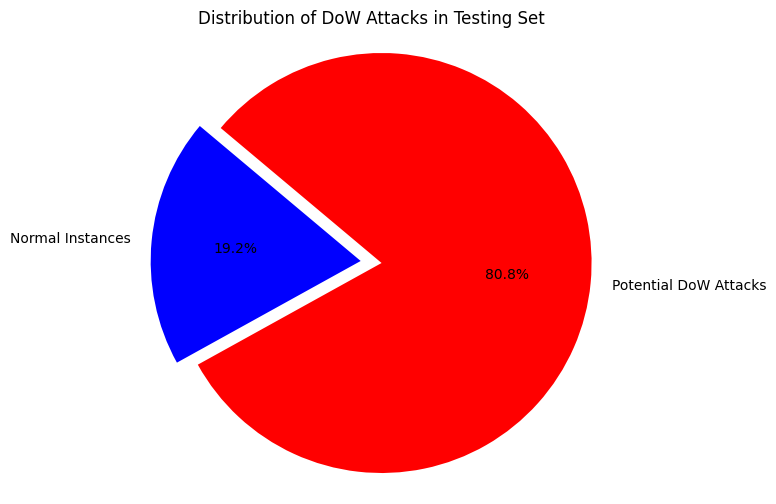

In [ ]:
import matplotlib.pyplot as plt

# Calculate the percentage of DoS attacks based on the testing set
total_instances_test = len(y_test)
dos_percentage_test = np.sum(y_test) / total_instances_test * 100
normal_percentage_test = 100 - dos_percentage_test

# Pie chart for the distribution of DoS attacks in the testing set
labels = ['Normal Instances', 'Potential DoW Attacks']
sizes = [normal_percentage_test, dos_percentage_test]
colors = ['blue', 'red']  # Using a contrasting color for DoS attacks
explode = (0, 0.1)  # Explode the 2nd slice (i.e., 'Potential DoS Attacks')

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of DoW Attacks in Testing Set')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

Number of potential DoW attacks: 0
Sample of potential DoW attacks:
Empty DataFrame
Columns: [Id, IP, bot, FunctionId, functionTrigger, timestamp, SubmitTime, RTT, InvocationDelay, ResponseDelay, FunctionDuration, ActiveFunctionsAtRequest, ActiveFunctionsAtResponse, maxcpu, avgcpu, p95maxcpu, vmcategory, vmcorecountbucket, vmmemorybucket, RTT_entropy, InvocationDelay_entropy, ResponseDelay_entropy, FunctionDuration_entropy, ActiveFunctionsAtRequest_entropy, ActiveFunctionsAtResponse_entropy, maxcpu_entropy, avgcpu_entropy, p95maxcpu_entropy, vmcorecountbucket_entropy, vmmemorybucket_entropy]
Index: []

[0 rows x 30 columns]


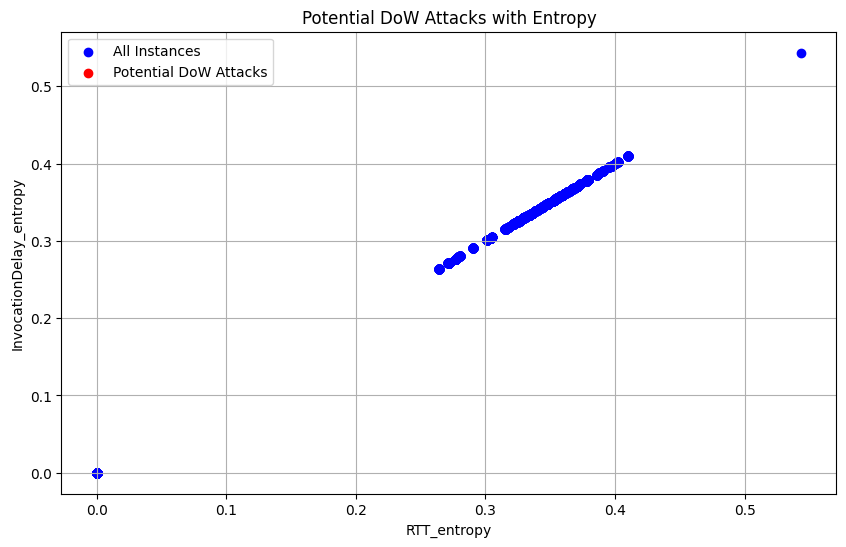

In [ ]:
# Get the indices of the testing set
test_indices = np.arange(len(X_train), len(X_train) + len(X_test))

# Filter data to include only samples from the testing set
data_test = data.iloc[test_indices]

# Define entropy threshold
entropy_threshold = -1.442695e-10  # Example threshold value

# Detect potential DoS attacks based on model predictions and entropy values
potential_dos_mask = (
    (y_pred_binary_flat == 1) &
    (data_test['RTT_entropy'] > entropy_threshold) &
    (data_test['InvocationDelay_entropy'] > entropy_threshold) &
    (data_test['ResponseDelay_entropy'] > entropy_threshold) &
    (data_test['FunctionDuration_entropy'] > entropy_threshold) &
    (data_test['ActiveFunctionsAtRequest_entropy'] > entropy_threshold) &
    (data_test['ActiveFunctionsAtResponse_entropy'] > entropy_threshold) &
    (data_test['maxcpu_entropy'] > entropy_threshold) &
    (data_test['avgcpu_entropy'] > entropy_threshold) &
    (data_test['p95maxcpu_entropy'] > entropy_threshold) &
    (data_test['vmcorecountbucket_entropy'] > entropy_threshold) &
    (data_test['vmmemorybucket_entropy'] > entropy_threshold)
)

# Print the number of potential DoS attacks identified
print("Number of potential DoW attacks:", np.sum(potential_dos_mask))

# Inspect a sample of the DataFrame to ensure the filtering is correct
print("Sample of potential DoW attacks:")
print(data_test[potential_dos_mask].head())

# Choose two entropy features for visualization
entropy_feature1 = 'RTT_entropy'
entropy_feature2 = 'InvocationDelay_entropy'

# Plot potential DoS attacks with corresponding entropy values
plt.figure(figsize=(10, 6))
plt.scatter(data_test[entropy_feature1], data_test[entropy_feature2], c='blue', label='All Instances')
plt.scatter(data_test[potential_dos_mask][entropy_feature1], data_test[potential_dos_mask][entropy_feature2], c='red', label='Potential DoW Attacks')
plt.xlabel(entropy_feature1)
plt.ylabel(entropy_feature2)
plt.title('Potential DoW Attacks with Entropy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Function to calculate recall, specificity, and accuracy
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return accuracy, recall, specificity

# Function to plot sampling overhead (Figure 10)
def plot_sampling_overhead(function_requests, sampling_overhead_percentage):
    plt.figure(figsize=(8, 6))
    plt.plot(function_requests, sampling_overhead_percentage, marker='o')
    plt.xlabel('Function Requests')
    plt.ylabel('Sampling Overhead (%)')
    plt.title('Sampling Overhead of Gringotts')
    plt.grid(True)
    plt.show()

# Function to plot detection delay (Figure 11)
def plot_detection_delay(techniques, detection_delay_seconds):
    plt.figure(figsize=(8, 6))
    plt.bar(techniques, detection_delay_seconds)
    plt.xlabel('Detection Techniques')
    plt.ylabel('Detection Delay (Seconds)')
    plt.title('Comparison of Detection Delay')
    plt.grid(True)
    plt.show()

# Function to plot influence of detection threshold on metrics (Figure 12)
def plot_threshold_influence(threshold_values, recall_values, specificity_values, accuracy_values):
    plt.figure(figsize=(8, 6))
    plt.plot(threshold_values, recall_values, label='Recall')
    plt.plot(threshold_values, specificity_values, label='Specificity')
    plt.plot(threshold_values, accuracy_values, label='Accuracy')
    plt.xlabel('Threshold Value')
    plt.ylabel('Metric Value')
    plt.title('Influence of Detection Threshold on Metrics')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to plot influence of Hc factor on metrics (Figure 13)
def plot_hc_influence(hc_values, recall_values, specificity_values, accuracy_values):
    plt.figure(figsize=(8, 6))
    plt.plot(hc_values, recall_values, label='Recall')
    plt.plot(hc_values, specificity_values, label='Specificity')
    plt.plot(hc_values, accuracy_values, label='Accuracy')
    plt.xlabel('Hc Factor')
    plt.ylabel('Metric Value')
    plt.title('Influence of Hc Factor on Metrics')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to plot end-to-end evaluation results (Figure 14)
def plot_end_to_end_evaluation_results(models, accuracy_percentages, time_seconds):
    plt.figure(figsize=(8, 6))
    for model, accuracy_percentage in zip(models, accuracy_percentages):
        plt.plot(time_seconds, accuracy_percentage, label=model)
    plt.xlabel('Time (Seconds)')
    plt.ylabel('Accuracy (%)')
    plt.title('End-to-End Evaluation Results of Different Models')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Training History')
plt.legend()
plt.show()

# Plotting other graphs and calculating additional metrics

# Plotting Histogram of RTT values
plt.hist(data['RTT'], bins=20, color='blue', alpha=0.7)
plt.xlabel('RTT')
plt.ylabel('Frequency')
plt.title('Histogram of RTT values')
plt.show()

# Plotting Boxplot of Invocation Delay values
plt.boxplot(data['InvocationDelay'])
plt.xlabel('Invocation Delay')
plt.title('Boxplot of Invocation Delay values')
plt.show()

# Remove non-numeric and categorical columns
numeric_data = data.select_dtypes(include=['number'])

# Plotting Correlation Matrix
correlation_matrix = numeric_data.corr()
plt.matshow(correlation_matrix, cmap='viridis')
plt.colorbar()
plt.title('Correlation Matrix')
plt.show()

# Calculating and printing mean and standard deviation of Response Delay
response_delay_mean = data['ResponseDelay'].mean()
response_delay_std = data['ResponseDelay'].std()
print("Mean of Response Delay:", response_delay_mean)
print("Standard Deviation of Response Delay:", response_delay_std)

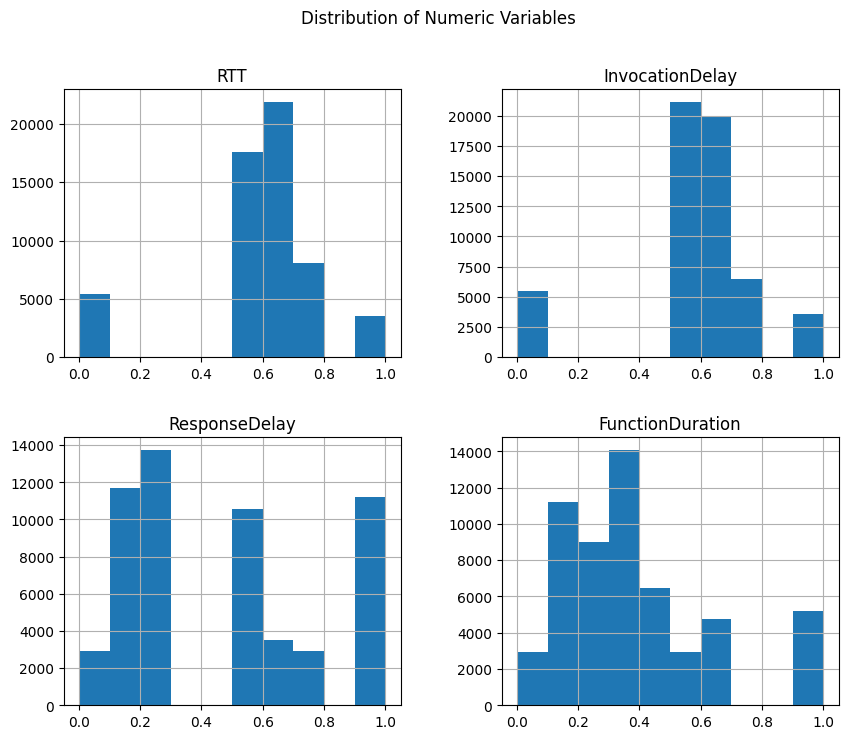

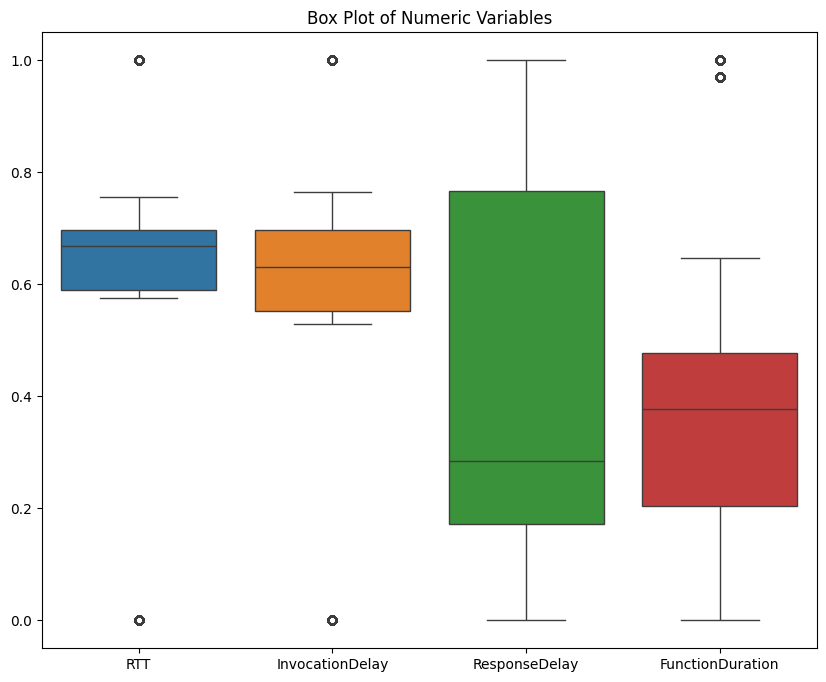

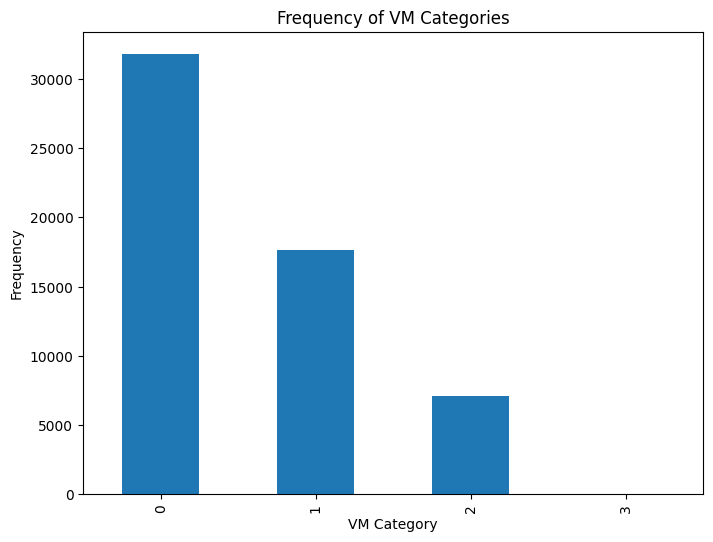

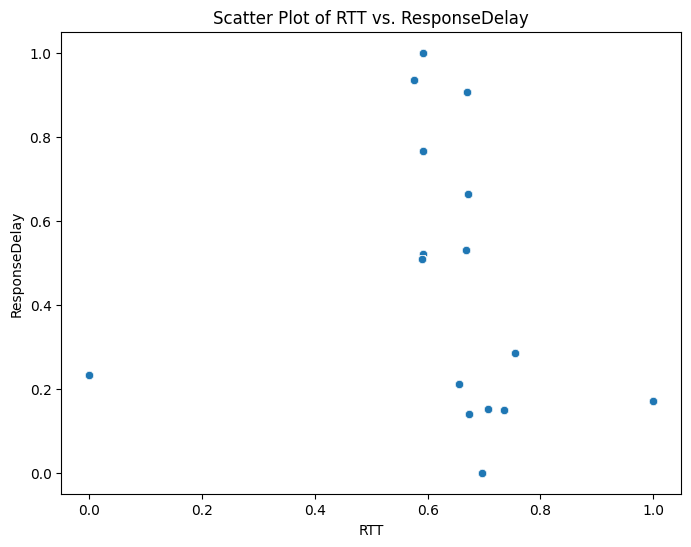

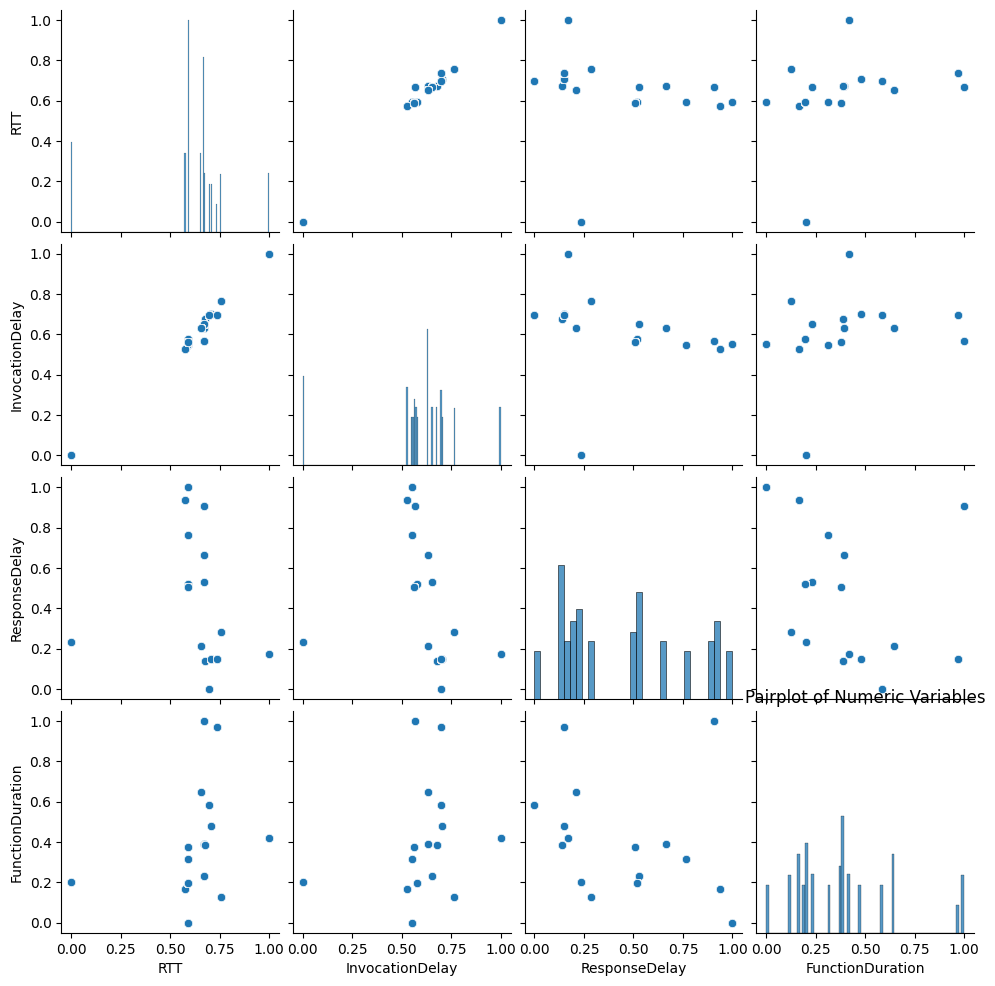

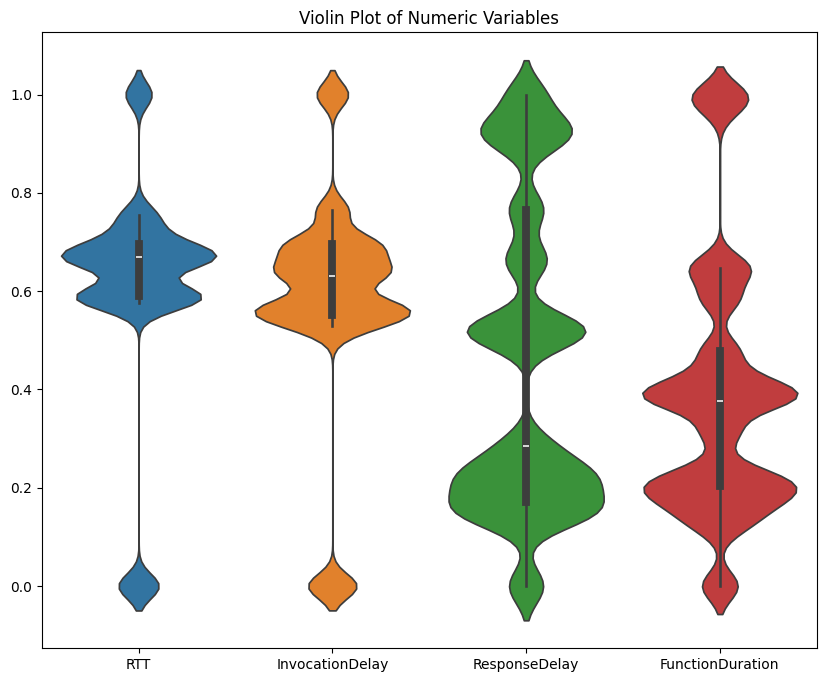

In [ ]:
import seaborn as sns

# Replace infinite values with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# 1. Histograms
data[['RTT', 'InvocationDelay', 'ResponseDelay', 'FunctionDuration']].hist(figsize=(10, 8))
plt.suptitle('Distribution of Numeric Variables')
plt.show()

# 2. Box Plots
plt.figure(figsize=(10, 8))
sns.boxplot(data=data[['RTT', 'InvocationDelay', 'ResponseDelay', 'FunctionDuration']])
plt.title('Box Plot of Numeric Variables')
plt.show()

# 3. Bar Plot for 'vmcategory'
plt.figure(figsize=(8, 6))
data['vmcategory'].value_counts().plot(kind='bar')
plt.title('Frequency of VM Categories')
plt.xlabel('VM Category')
plt.ylabel('Frequency')
plt.show()

# 4. Scatter Plot (e.g., 'RTT' vs. 'ResponseDelay')
plt.figure(figsize=(8, 6))
sns.scatterplot(x='RTT', y='ResponseDelay', data=data)
plt.title('Scatter Plot of RTT vs. ResponseDelay')
plt.show()

# 6. Pairplot (selecting a subset of columns for demonstration)
sns.pairplot(data[['RTT', 'InvocationDelay', 'ResponseDelay', 'FunctionDuration']])
plt.title('Pairplot of Numeric Variables')
plt.show()

# 7. Violin Plots
plt.figure(figsize=(10, 8))
sns.violinplot(data=data[['RTT', 'InvocationDelay', 'ResponseDelay', 'FunctionDuration']])
plt.title('Violin Plot of Numeric Variables')
plt.show()
